In [1]:
import pandas as pd
data= pd.read_csv(
    "winequalityN.csv"
    )

threshold = data['quality'].max()/2+1  # Define your threshold

data['quality'] = (data['quality'] > threshold).astype(int)
data['type'] = data['type'].apply(lambda x: 0 if x=='white' else 1)
counts = data['quality'].value_counts()
target_count = min(counts)
balanced_data = pd.concat([
    data[data['quality'] == 0].sample(target_count, replace=True),
    data[data['quality'] == 1].sample(target_count, replace=True)
])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
balanced_data['quality'].value_counts()
#data = balanced_data
features = data.copy()
features.fillna(0, inplace=True)
labels = features.pop('quality')
import numpy as np
features = np.array(features)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(features,labels):
    X_train, X_test = features[train_index],features[test_index]
    y_train, y_test = labels[train_index],labels[test_index]

In [3]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
estimators = [
    ('MLPClassifier',MLPClassifier(activation='tanh',learning_rate='constant',alpha=0,hidden_layer_sizes=(100, 100, 100))),
    ('DecisionTreeClassifier',DecisionTreeClassifier(ccp_alpha=0,max_depth=8,min_samples_leaf=2,min_samples_split=2)),
    ('KNeighborsClassifier',KNeighborsClassifier(algorithm='auto',leaf_size=20,n_neighbors=6,p=1,weights='distance')),
    ('SVC',SVC(C=10,kernel='rbf')),
    ('GaussianNB',GaussianNB()),
    ('LogisticRegression',LogisticRegression(penalty=None,dual=False,C=6,fit_intercept=True,intercept_scaling=1,class_weight=None,random_state=1,solver='lbfgs',multi_class='auto',l1_ratio=0)),
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
import warnings
warnings.filterwarnings("ignore")
clf.fit(X_train, y_train).score(X_test, y_test)

0.816923076923077

In [4]:
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)

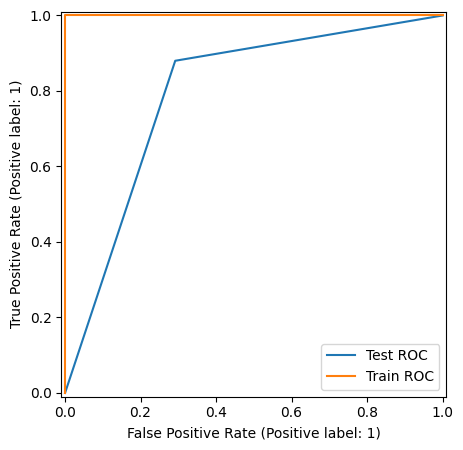

In [5]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test,predictions, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train,predictions_train, ax=ax, label='Train ROC')

In [7]:
import sklearn
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[ 507,  209],
       [ 148, 1086]], dtype=int64)

In [8]:
sklearn.metrics.f1_score(y_test,predictions,average=None)

array([0.73960613, 0.85883749])

In [9]:
sklearn.metrics.roc_curve(y_test,predictions)

(array([0.        , 0.29189944, 1.        ]),
 array([0.        , 0.88006483, 1.        ]),
 array([inf,  1.,  0.]))